# Background blurring using single image

### Introduction

Start here

In [105]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np

# modify to where you store your project data including utils
datadir = "./" 
images_path = "images"
input_path = "images/inputs"
output_path = "images/outputs"

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/inputs/"
!mkdir "images/outputs/"

mkdir: images: File exists
mkdir: images/inputs/: File exists
mkdir: images/outputs/: File exists


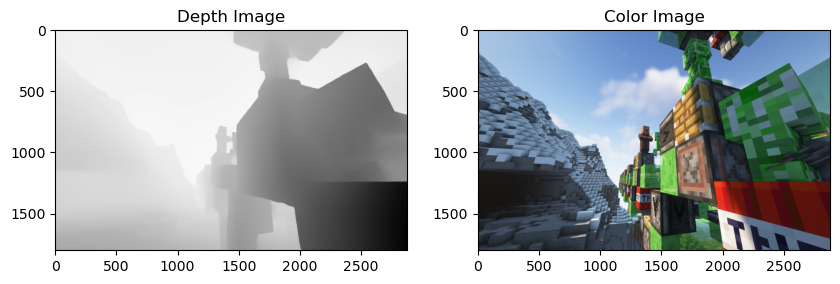

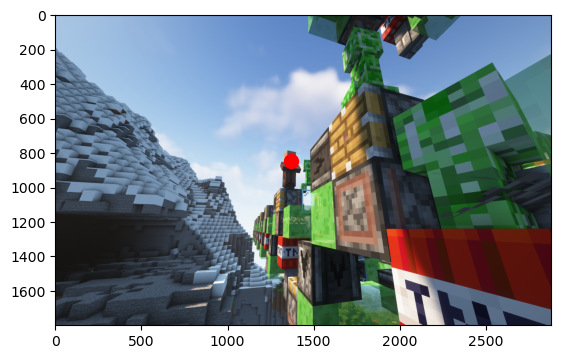

In [106]:
# read depth image and color image
# cimg = cv2.imread("images/inputs/c8.jpg")
# dimg = cv2.imread("images/inputs/d8.jpeg", cv2.IMREAD_ANYDEPTH)

cimg = cv2.imread("images/inputs/c11.png")
dimg = cv2.imread("images/inputs/d11.jpeg", cv2.IMREAD_ANYDEPTH)

# cimg = cv2.imread("images/inputs/c4.JPG")
# dimg = cv2.imread("images/inputs/d4.png", cv2.IMREAD_ANYDEPTH)

cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)

# invert depth image. The rest of our code assumes the closer object has lower depth value
dimg = np.max(dimg) - dimg

# # parameters for pairs 1
# position = (150, 500)
# blur_lv = 20
# step = 30

# # parameters for pairs 2
# position = (840, 1080)
# blur_lv = 20
# step = 1

# # parameters for pairs 3
# position = (int(cimg.shape[0]/2), int(cimg.shape[1]/2))
# blur_lv = 20
# step = 1

# # parameters for pairs 4
# position = (1700, 2600)
# blur_lv = 20
# step = 3

# # parameters for pairs 5
# position = (2000, 1500)
# blur_lv = 20
# step = 3


# # parameters for pairs 6
# position = (2420, 1330)
# blur_lv = 10
# step = 8

# # parameters for pairs 8
# position = (2478, 1471)
# blur_lv = 20
# step = 3

# # parameters for pairs 9
# position = (637, 721)
# blur_lv = 10
# step = 5

# # parameters for pairs 10
# position = (585, 771)
# blur_lv = 30
# step = 3

# parameters for pairs 11
position = (845, 1371)
blur_lv = 30
step = 3

# show depth image
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(dimg, cmap='gray')
plt.title("Depth Image")
plt.subplot(1,2,2)
plt.imshow(cimg)
plt.title("Color Image")
plt.show()

# show the focus position
plt.figure()
plt.imshow(cimg)
plt.scatter(position[1], position[0], c='r', s=100)
plt.show()

## Part 1: Naive Background Blur using Depth Image

In [107]:
def assign_levels(dimg, blur_lv, pos):
  # set up constants
  h,w = dimg.shape
  furthest = np.max(dimg)
  closest = np.min(dimg)
  focus_depth = dimg[pos[0], pos[1]]

  # divide the depth range into blur_lv levels. d is the depth range of each level
  dr = max(abs(furthest - focus_depth), abs(focus_depth - closest)) / (blur_lv)

  # given a depth, calculate its blur level
  def calc_level(x):
    nonlocal focus_depth
    if x == focus_depth:
      return 0

    return int(abs(int(x) - int(focus_depth)) / dr)

  # assign blur levels to each pixel
  level_image = np.zeros((h,w),dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      level_image[i,j] = calc_level(dimg[i,j])

  return level_image
  

In [108]:
def blur_img(cimg, blur_lv, step):
  kernel_size = 2 * step * blur_lv + 3
  return cv2.GaussianBlur(cimg, (kernel_size, kernel_size), 0)


def get_blurred_imgs(cimg, blur_lv, step):
  # create multiple blurred images based on blur level
  blurred_imgs = [cimg.copy()]
  for i in range(blur_lv):
    blurred_imgs.append(blur_img(cimg, i, step))


  return blurred_imgs

In [109]:
def naive_blur(dimg, cimg, pos, blur_lv=20, step=3):
  '''
  The given position will be clear
  The other regions will be blurred based on the depth map

  dimg: depth image
  cimg: color image
  pos: position of the object to be clear
  blur_lv: blur level

  return: blurred image
  '''
  assert dimg.shape == cimg.shape[:2]

  # set up constants
  h,w = dimg.shape

  blurred_imgs = get_blurred_imgs(cimg, blur_lv, step)
  level_image = assign_levels(dimg, blur_lv, pos)

  # combine the blurred images based on the blur level at each pixel
  # get the pixel from the corresponding blurred image
  output = np.zeros((h,w,3),dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      output[i,j] = blurred_imgs[level_image[i,j]][i,j]
  
  return output

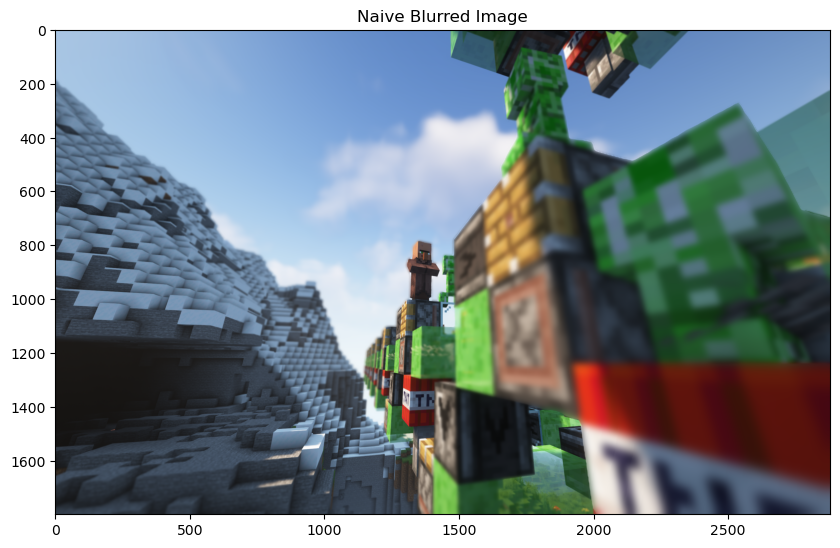

True

In [110]:
naive_blur_img = naive_blur(dimg, cimg, position, blur_lv=blur_lv, step=step)
# show blurred image
plt.figure(figsize=(10,10))
plt.imshow(naive_blur_img)
plt.title("Naive Blurred Image")
plt.show()

# from RGB to BGR
naive_blur_img = naive_blur_img[:,:,::-1]
# write blurred image
cv2.imwrite("images/outputs/naive_blur.png", naive_blur_img)

## Part 2: Reducing edge blurring using Depth Image

We observe that the edges of the foreground object are also blurred. This is because the Gaussian blurring of the background image is using the pixels of the foreground object. To avoid this, we want to do the following steps:

1. Create a mask of the foreground object
2. Do some simple hole filling to fill in the holes in the mask
3. The rest is the same as before.

In [111]:
# Step 1: create a mask for the selected object.
# Naively, we simply build a mask that excludes all pixels that are not blurred.

def create_mask(level_image, blur_lv):
  mask = np.zeros(level_image.shape, dtype=np.uint8)
  mask[level_image < blur_lv] = 255
  return mask

In [112]:
def hole_fill(image, mask, radius=3, level=1):
  img = image.copy()
  # remove the mask area from the image
  img[mask == 255] = 0

  # # Uncomment these four lines to see the affected area of naive blur
  # red = (blur_lv - level) * 255 / blur_lv
  # green = 255 - red
  # img[mask == 255] = np.array([red, green,0])
  # return img

  # from RGB to BGR
  img = img[:,:,::-1]
  # write img to disk
  cv2.imwrite("images/outputs/all_levels/masked{}.png".format(level), img)
  # from BGR to RGB
  img = img[:,:,::-1]

  # fill the hole using OpenCV inpainting
  return cv2.inpaint(img, mask, radius, cv2.INPAINT_TELEA)

In [113]:
def enhanced_blur_background(dimg, cimg, pos, blur_lv=5, step=1):

  # blur the dimg to filter noisy depth info
  dimg = cv2.GaussianBlur(dimg, (5, 5), 0)

  level_image = assign_levels(dimg, blur_lv, pos)
  
  # step 1: create a mask for the selected object
  mask_arr = []
  for i in range(blur_lv):
    mask_arr.append(create_mask(level_image, i))
  
  # step 2: fill the hole and blur the filled image
  blurred_imgs = [cimg.copy()]
  for i in range(blur_lv):
    filled_img = hole_fill(cimg, mask_arr[i], 5, i)
    blurred_imgs.append(blur_img(filled_img, i, step))

  # step 3: combine the blurred images based on the blur level at each pixel
  h,w = dimg.shape
  output = np.zeros((h,w,3),dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      output[i,j] = blurred_imgs[level_image[i,j]][i,j]
    
  return output

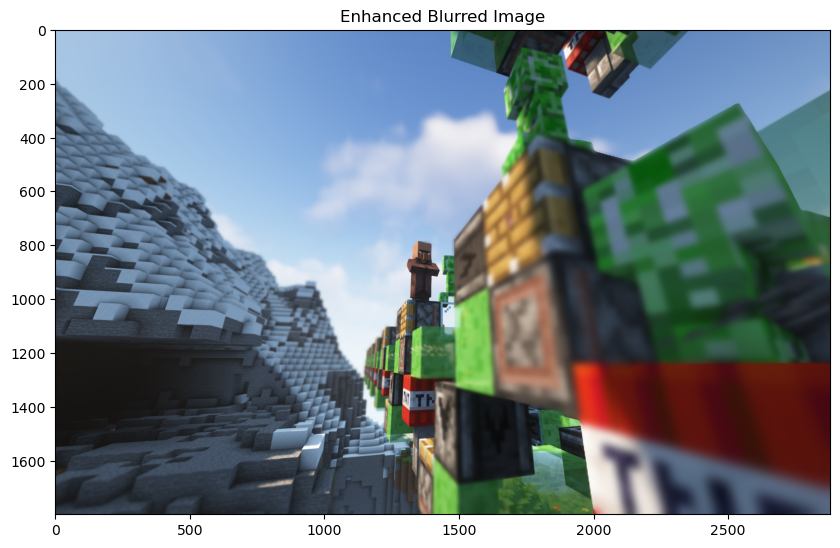

True

In [114]:
better_blur = enhanced_blur_background(dimg, cimg, position, blur_lv=blur_lv, step=step)
# show blurred image
plt.figure(figsize=(10,10))
plt.imshow(better_blur)
plt.title("Enhanced Blurred Image")
plt.show()

# from RGB to BGR
better_blur = better_blur[:,:,::-1]
# write blurred image
cv2.imwrite("images/outputs/better_blur.png", better_blur)

### Part 2.5: Smarter inpainting

We noticed that, when some of the background has huge different in relative depth, the boundary of the inpainted region is very obvious. However, if the relative depth is huge while both levels are deep, the boundary should not be obvious.

To avoid this, we want to reduce the effect of inpainting algorithm as the blurring level increases.

When implementing this, we noticed that the only change to make is the final step of getting different levels of blurred images for each pixel. As we have already created two versions of the blurred image, we can try to take the weighted average of the two images.